## Assignment 7: Exercise 1

Deadline 22.05.2025 at 00.00

### Text-to-speech (TTS) synthesis with Tacotron 2 and HiFi-GAN

In this exercise we duplicate parts of a pre-trained TTS system based on Tacotron 2 and HiFi-GAN. The implementation needs to be compatible with the original implementation and referencing the original source code is advised. Links will be provided where applicable.

The intended learning outcomes are to understand the architectures at a high level, navigate complex working codebases, and re-implement the crucial parts related to attention and autoregressive sampling.

## Before the Assignment

Please give a brief read to the following papers:

- [Natural TTS Synthesis by Conditioning WaveNet on Mel Spectrogram Predictions](https://arxiv.org/abs/1712.05884)  
  This paper introduces **Tacotron 2**, a neural sequence-to-sequence model that predicts mel-scale spectrograms from text and then uses a modified WaveNet vocoder to synthesize time-domain waveforms.

- [HiFi-GAN: Generative Adversarial Networks for Efficient and High Fidelity Speech Synthesis](https://arxiv.org/abs/2010.05646)  
  HiFi-GAN is a GAN-based neural vocoder designed to convert Mel spectrograms into raw audio waveforms with both high fidelity and real-time efficiency. We will use HiFi_GAN (instead of the original WaveNet vocoder) to synthesize time-domain waveforms from the mel spectrograms produced by the Tacotron2 model.



### Install text-processing libraries -- Asenna tekstinkäsittelykirjastot


In [3]:
%pip install unidecode
%pip install inflect

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Tacotron 2 and HiFi-GAN

Let's clone the [Tacotron 2](https://github.com/NVIDIA/tacotron2.git) and [HiFi-GAN](https://github.com/jik876/hifi-gan.git) repositories from github. We will also load the pre-trained model weights for the tacotron model from a dedicated [Aalto Gitlab repository](https://version.aalto.fi/gitlab/speech-synthesis-releases/tacotron-models.git). The rest of the section is mostly utility code to manage non-packaged python code. 


In [4]:
import sys
import os

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import numpy as np
import torch
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

# HERE WE LOAD THE ARCHITECTURE OF THE TACOTRON MODEL
if not os.path.isdir('tacotron2'):
    !git clone https://github.com/NVIDIA/tacotron2.git
    !touch tacotron2/__init__.py
    pass

# HERE WE LOAD THE ARCHITECTURE OF THE HIFI GAN MODEL
if not os.path.isdir('hifi_gan'):
    !git clone https://github.com/jik876/hifi-gan.git
    !mv hifi-gan hifi_gan
    !touch hifi_gan/__init__.py
    pass

# HERE WE LOAD THE WEIGHTS OF THE PRETRAINED MODELS
if not os.path.isdir('tacotron-models'):
    !git clone https://version.aalto.fi/gitlab/speech-synthesis-releases/tacotron-models.git
    !touch tacotron2/__init__.py
    pass

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
        
with add_path(os.path.realpath('.')):

    print("Working dir:", os.getcwd())
    print("Contents:", os.listdir('./tacotron2'))
    
    from tacotron2.model import *
    from tacotron2.layers import *
    from tacotron2.text import *

def load_model(hparams):
    model = Tacotron2(hparams)
    return model

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')


Working dir: /notebooks/dgm2025/assignment7
Contents: ['Dockerfile', 'LICENSE', 'README.md', 'audio_processing.py', 'data_utils.py', 'demo.wav', 'distributed.py', 'hparams.py', 'layers.py', 'logger.py', 'loss_function.py', 'loss_scaler.py', 'model.py', 'multiproc.py', 'plotting_utils.py', 'requirements.txt', 'stft.py', 'tensorboard.png', 'train.py', 'utils.py', '__init__.py', 'filelists', 'text', '__pycache__']


### Tacotron 2 configuration parameters

The original code uses a deprecated Tensorflow class for storing hyperparameters. Luckily, the functionality is identical to a standard python dataclass. This also gives us a chance to look at all the Tacotron 2 configuration parameters.



In [5]:
# hyperparameter dataclass
from dataclasses import dataclass
n_symbols = len(symbols)

@dataclass
class HParams:
    ################################
    # Experiment Parameters        #
    ################################
    dynamic_loss_scaling=True
    fp16_run=False
    distributed_run=False
    dist_backend="nccl"
    dist_url="tcp://localhost:54321"
    cudnn_enabled=True
    cudnn_benchmark=False
    ignore_layers=['embedding.weight']

    ################################
    # Data Parameters             #
    ################################
    load_mel_from_disk=False,
    training_files='filelists/ljs_audio_text_train_filelist.txt'
    validation_files='filelists/ljs_audio_text_val_filelist.txt'
    text_cleaners=['english_cleaners']

    ################################
    # Audio Parameters             #
    ################################
    max_wav_value=32768.0
    sampling_rate=22050
    filter_length=1024
    hop_length=256
    win_length=1024
    n_mel_channels=80
    mel_fmin=0.0
    mel_fmax=8000.0

    ################################
    # Model Parameters             #
    ################################
    n_symbols=n_symbols
    symbols_embedding_dim=512

    # Encoder parameters
    encoder_kernel_size=5
    encoder_n_convolutions=3
    encoder_embedding_dim=512

    # Decoder parameters
    n_frames_per_step=1  # currently only 1 is supported
    decoder_rnn_dim=1024
    prenet_dim=256
    max_decoder_steps=1000
    gate_threshold=0.5
    p_attention_dropout=0.1
    p_decoder_dropout=0.1

    # Attention parameters
    attention_rnn_dim=1024
    attention_dim=128

    # Location Layer parameters
    attention_location_n_filters=32
    attention_location_kernel_size=31

    # Mel-post processing network parameters
    postnet_embedding_dim=512
    postnet_kernel_size=5
    postnet_n_convolutions=5

    ################################
    # Optimization Hyperparameters #
    ################################
    use_saved_learning_rate=False
    learning_rate=1e-3
    weight_decay=1e-6
    grad_clip_thresh=1.0
    batch_size=64
    mask_padding=True  # set model's padded outputs to padded values


### Loading a pre-trained Tacotron 2 model

We load the weights of a single speaker model pre-trained on the [LJSpeech dataset](https://pytorch.org/audio/main/generated/torchaudio.datasets.LJSPEECH.html) from the weights directory we downloaded before.


In [6]:
hparams = HParams()
hparams.sampling_rate = 22050

checkpoint_path = os.path.join(os.getcwd(), "tacotron-models/tacotron-models/tacotron2_statedict.pt") 
tacotron = load_model(hparams)
state_dict = torch.load(checkpoint_path, map_location='cpu')
tacotron.load_state_dict(state_dict['state_dict'])

# DISPLAY THE ARCHITECTURE OF THE MODEL
tacotron.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

### Implementing the Tacotron 2 inference functions

In this section your task is to implement the inference function. You can and should reference the [original implementation](https://github.com/NVIDIA/tacotron2/blob/185cd24e046cc1304b4f8e564734d2498c6e2e6f/model.py) on GitHub.




In [7]:
def attention_forward(self, attention_hidden_state, memory, processed_memory,
                    attention_weights_cat, mask):
    """
    PARAMS
    ------
    attention_hidden_state: attention rnn last output
    memory: encoder outputs
    processed_memory: processed encoder outputs
    attention_weights_cat: previous and cumulative attention weights
    mask: binary mask for padded data
    """
    
    alignment = self.get_alignment_energies(
        attention_hidden_state, processed_memory, attention_weights_cat)

    if mask is not None:
        alignment.data.masked_fill_(mask, self.score_mask_value)
        
    # Get attention weights by normalising alignment with softmax
    # YOUR CODE HERE
    attention_weights = F.softmax(alignment, dim=1)
    #raise NotImplementedError()
    
    # Apply matrix multiplication between attention weights and memory
    # YOUR CODE HERE
    attention_context = torch.bmm(attention_weights.unsqueeze(1), memory)
    attention_context = attention_context.squeeze(1)
    
    #raise NotImplementedError()
    
    return attention_context, attention_weights



### Testing the Attention implementation (1 point)

In [8]:
Attention.forward = attention_forward

attention_layer = Attention(
            hparams.attention_rnn_dim, hparams.encoder_embedding_dim,
            hparams.attention_dim, hparams.attention_location_n_filters,
            hparams.attention_location_kernel_size)

batch_size = 1
num_characters = 44

attention_hidden_state = torch.randn(batch_size, hparams.attention_rnn_dim) # (1, 1024)
memory = torch.randn(batch_size, num_characters, hparams.encoder_embedding_dim) # (1, 44, 512)
processed_memory = torch.randn(batch_size, num_characters,  hparams.attention_dim) # (1, 44, 128)
attention_weights_cat = torch.randn(batch_size, 2, num_characters) # (1, 2, 44)

mask = None

attention_context, attention_weights = attention_layer(attention_hidden_state, memory,
                                                       processed_memory, attention_weights_cat, mask)

assert attention_context.shape == (batch_size, hparams.encoder_embedding_dim), \
    print(f"Expected shape {(batch_size, hparams.encoder_embedding_dim)}, but got {attention_context.shape}")
assert attention_weights.shape == (batch_size, num_characters), \
    print(f"Expected shape {(batch_size, num_characters)}, but got {attention_weights.shape}")



### Decoding function

Let's look a the Tacotron 2 decoding function. We will call this function repeatedly to generate the mel spectrogram frame by frame.

No changes required for this section.



In [9]:
def decoder_decode(self, decoder_input):
    """ Decoder step using stored states, attention and memory
    PARAMS
    ------
    decoder_input: previous mel output

    RETURNS
    -------
    mel_output:
    gate_output: gate output energies
    attention_weights:
    """
    cell_input = torch.cat((decoder_input, self.attention_context), -1)
    self.attention_hidden, self.attention_cell = self.attention_rnn(
        cell_input, (self.attention_hidden, self.attention_cell))
    self.attention_hidden = F.dropout(
        self.attention_hidden, self.p_attention_dropout, self.training)

    attention_weights_cat = torch.cat(
        (self.attention_weights.unsqueeze(1),
         self.attention_weights_cum.unsqueeze(1)), dim=1)
    self.attention_context, self.attention_weights = self.attention_layer(
        self.attention_hidden, self.memory, self.processed_memory,
        attention_weights_cat, self.mask)

    self.attention_weights_cum += self.attention_weights
    decoder_input = torch.cat(
        (self.attention_hidden, self.attention_context), -1)
    self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
        decoder_input, (self.decoder_hidden, self.decoder_cell))
    self.decoder_hidden = F.dropout(
        self.decoder_hidden, self.p_decoder_dropout, self.training)

    decoder_hidden_attention_context = torch.cat(
        (self.decoder_hidden, self.attention_context), dim=1)
    decoder_output = self.linear_projection(
        decoder_hidden_attention_context)

    gate_prediction = self.gate_layer(decoder_hidden_attention_context)
    return decoder_output, gate_prediction, self.attention_weights

# add the new method to the Decoder class
Decoder.decode = decoder_decode

### Decoder inference function

In this section we implement the decoder inference function. This function will call the decoder repeatedly to generate the mel spectrogram frame by frame.

Check the original source code for reference.



In [10]:
def decoder_inference(self, memory):
        """ Decoder inference
        PARAMS
        ------
        memory: Encoder outputs

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        decoder_input = self.get_go_frame(memory)

        self.initialize_decoder_states(memory, mask=None)

        mel_outputs, gate_outputs, alignments = [], [], []
        # run the decoder loop, generate mel outputs one frame at a time
        while True:
            decoder_input = self.prenet(decoder_input)
            mel_output, gate_output, alignment = self.decode(decoder_input)

            # collect outputs in lists
            # YOUR CODE HERE
            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output.squeeze(1)]
            alignments += [alignment]
            #raise NotImplementedError()

            # check stopping criterion and break if needed (use self.gate_threshold)
            # YOUR CODE HERE
            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            
            #raise NotImplementedError()

            # stop if max decoder steps is reached (use self.max_decoder_steps)
            # YOUR CODE HERE
            elif len(mel_outputs) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break
            #raise NotImplementedError()

            decoder_input = mel_output

        # convert lists to tensors
        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)
        
        return mel_outputs, gate_outputs, alignments
    
# add the new method to the Decoder class
Decoder.inference = decoder_inference

### Tacotron2 whole model inference

In this section we implement infrence for the whole Tacotron 2 model. Encoder works in a single pass for the entire sequence, but the decoder needs to be called repeatedly to generate the mel spectrogram frame by frame.

Reference the original source code for the Tacotron 2 model for implementation details.



In [11]:
def inference(self, inputs):
    """ 
    Args:
        inputs: (batch, n_chars)

    Returns:
        mel_outputs: (batch, n_mel_channels, T_out)
        mel_outputs_postnet: (batch, n_mel_channels, T_out)
        gate_outputs: (batch, T_out)
        alignments: (batch, T_out, n_chars)
        embedded_inputs: (batch, n_chars, symbols_embedding_dim)
        encoder_outputs: (batch, n_chars, encoder_embedding_dim)

    """
    # YOUR CODE HERE
    embedded_inputs = self.embedding(inputs).transpose(1,2)
    encoder_outputs = self.encoder.inference(embedded_inputs)
    
    mel_outputs, gate_outputs, alignments = self.decoder.inference(encoder_outputs)
    
    mel_outputs_postnet = self.postnet(mel_outputs)
    mel_outputs_postnet = mel_outputs + mel_outputs_postnet
    
    
    #raise NotImplementedError()
    return mel_outputs, mel_outputs_postnet, gate_outputs, alignments, embedded_inputs, encoder_outputs 

# set custom forward function
Tacotron2.inference = inference

### Mel-spectrogram synthesis and attention alignment

Let's synthesize an utterance and inspect the the mel-spectrogram and attention plots. We will use a waveform synthesis model later to actually listen to the output.


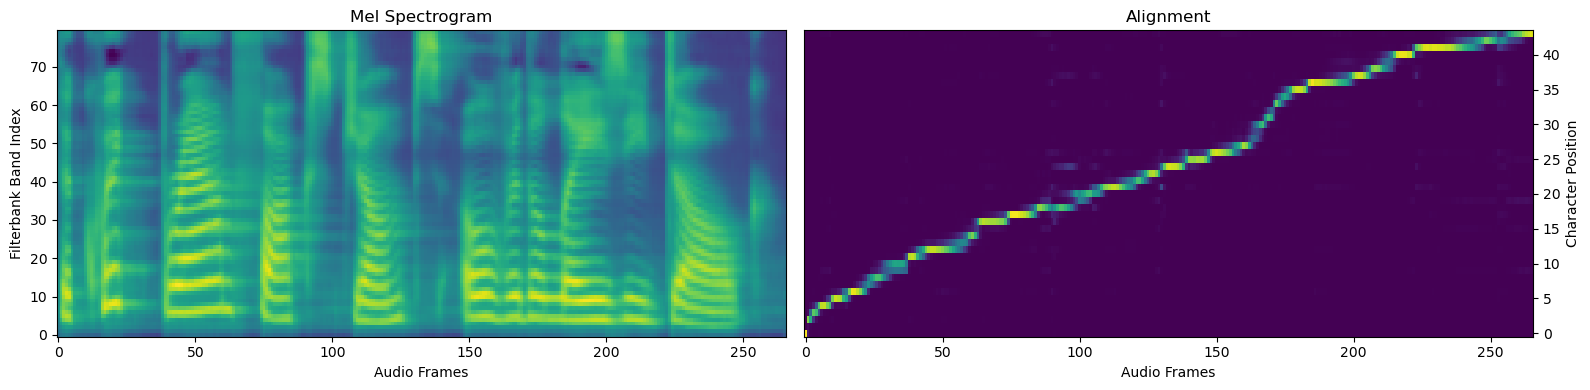

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from tacotron2.text import text_to_sequence   # adjust import if you changed paths

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i, ax in enumerate(axes):
        im = ax.imshow(data[i],
                       aspect='auto',
                       origin='lower',
                       interpolation='none')
        if i == 0:
            ax.set_title("Mel Spectrogram")
            ax.set_xlabel("Audio Frames")
            ax.set_ylabel("Filterbank Band Index")
        else:
            ax.set_title("Alignment")
            ax.set_xlabel("Audio Frames")
            ax.set_ylabel("Character Position")
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
    plt.tight_layout()
    return fig

text     = "The quick brown fox jumps over the lazy dog."
seq      = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.LongTensor(seq)

torch.manual_seed(0)
mel_outputs, mel_outputs_postnet, gate_outputs, alignments, embedded_inputs, encoder_outputs = \
    tacotron.inference(sequence)

fig = plot_data((
    mel_outputs[0].detach().cpu().numpy(),
    alignments[0].detach().cpu().numpy().T
))
plt.show()



### Checking that the model output is correct (3 sections, 1 point each)

The following code checks that the model output is correctly shaped.


In [13]:
torch.manual_seed(0)
mel_outputs, mel_outputs_postnet, gate_outputs, alignments, embedded_inputs, encoder_outputs  = tacotron.inference(sequence)

n_frames = mel_outputs.shape[2]
n_chars = sequence.shape[1]
batch_size = 1

print(f"Mel outputs shape {mel_outputs.shape}")
assert mel_outputs.shape[0] == batch_size, \
    f"Expected shape {batch_size}, but got {mel_outputs.shape[0]}"
assert mel_outputs.shape[1] == hparams.n_mel_channels, \
    f"Expected shape {hparams.n_mel_channels}, but got {mel_outputs.shape[1]}"

print("Tests ok")

print(f"Mel outputs postnet shape {mel_outputs_postnet.shape}")
assert mel_outputs_postnet.shape[0] == batch_size, \
    f"Expected shape {batch_size}, but got {mel_outputs_postnet.shape[0]}"
assert mel_outputs_postnet.shape[1] == hparams.n_mel_channels, \
    f"Expected shape {hparams.n_mel_channels}, but got {mel_outputs_postnet.shape[1]}"
assert mel_outputs_postnet.shape[2] == n_frames, \
    f"Expected shape {n_frames}, but got {mel_outputs_postnet.shape[2]}"
print("Tests ok")



Mel outputs shape torch.Size([1, 80, 266])
Tests ok
Mel outputs postnet shape torch.Size([1, 80, 266])
Tests ok


In [14]:
torch.manual_seed(0)
mel_outputs, mel_outputs_postnet, gate_outputs, alignments, embedded_inputs, encoder_outputs  = tacotron.inference(sequence)

n_frames = mel_outputs.shape[2]
n_chars = sequence.shape[1]
batch_size = 1

print(f"Gate outputs shape {gate_outputs.shape}")
assert gate_outputs.shape[0] == batch_size, \
    f"Expected shape {batch_size}, but got {gate_outputs.shape[0]}"
assert gate_outputs.shape[1] == n_frames, \
    f"Expected shape {n_frames}, but got {gate_outputs.shape[1]}"
print("Tests ok")

print(f"Alignments shape {alignments.shape}")
assert alignments.shape[0] == batch_size, \
    f"Expected shape {batch_size}, but got {alignments.shape[0]}"
assert alignments.shape[1] == n_frames, \
    f"Expected shape {n_frames}, but got {alignments.shape[1]}"
assert alignments.shape[2] == n_chars, \
    f"Expected shape {n_chars}, but got {alignments.shape[2]}"
print("Tests ok")



Gate outputs shape torch.Size([1, 266])
Tests ok
Alignments shape torch.Size([1, 266, 44])
Tests ok


In [15]:
torch.manual_seed(0)
mel_outputs, mel_outputs_postnet, gate_outputs, alignments, embedded_inputs, encoder_outputs  = tacotron.inference(sequence)

n_frames = mel_outputs.shape[2]
n_chars = sequence.shape[1]
batch_size = 1

print(f"Embedded inputs shape {embedded_inputs.shape}")
assert embedded_inputs.shape[0] == batch_size
assert embedded_inputs.shape[1] == hparams.symbols_embedding_dim
assert embedded_inputs.shape[2] == n_chars
print("Tests ok")

print(f"Encoder outputs shape {encoder_outputs.shape}")
assert encoder_outputs.shape[0] == batch_size
assert encoder_outputs.shape[1] == n_chars
assert encoder_outputs.shape[2] == hparams.encoder_embedding_dim
print("Tests ok")


Embedded inputs shape torch.Size([1, 512, 44])
Tests ok
Encoder outputs shape torch.Size([1, 44, 512])
Tests ok


### HiFi-GAN waveform generator

Let's load a HiFi-GAN neural vocoder model. This model is speaker-specific, it has been trained on the LJSpeech dataset and fine-tuned use with Tacotron 2.


In [16]:
import json

matplotlib_backend = matplotlib.get_backend()


print(sys.path)
if 'utils' in sys.modules:  
    del sys.modules["utils"]
with add_path(os.path.realpath('./hifi_gan')):
    hifi_gan = __import__('hifi_gan')
    from hifi_gan.models import Generator as HiFiGAN
    from hifi_gan.inference import load_checkpoint
    from hifi_gan.env import AttrDict

matplotlib.use(matplotlib_backend)


model_dir = os.path.join(os.getcwd(), 'tacotron-models/hifigan-models/LJ_FT_T2_V3/')
model_file = os.path.join(model_dir, 'generator_v3')
config_file = os.path.join(model_dir, 'config.json')

state_dict = load_checkpoint(model_file, device='cpu')

with open(config_file) as f:
    data = f.read()

json_config = json.loads(data)
h = AttrDict(json_config)

print(state_dict.keys())

hifigan = HiFiGAN(h)
hifigan.load_state_dict(state_dict['generator'])

['/notebooks/dgm2025/assignment7', '/course/pymod', '/m/jhnas/jupyter/software/pymod', '/opt/software/lib/python310.zip', '/opt/software/lib/python3.10', '/opt/software/lib/python3.10/lib-dynload', '', '/opt/software/lib/python3.10/site-packages', '/opt/software/lib/python3.10/site-packages/boto-2.49.0-py3.10.egg']
Loading '/notebooks/dgm2025/assignment7/tacotron-models/hifigan-models/LJ_FT_T2_V3/generator_v3'
Complete.
dict_keys(['generator'])


<All keys matched successfully>

### HiFi-GAN generator forward pass

The HiFi-GAN generator model takes a frame-rate mel spectrogram and progressively upsamples it to a waveform at an audio sample rate.

In this section, your task is to implement the forward pass for the generator. In addition to the original functionality, you should collect the intermediate upsampled representations and return them in a list.

The forward pass needs to be compatible with the [original implementation](
https://github.com/jik876/hifi-gan/blob/4769534d45265d52a904b850da5a622601885777/models.py#L75).



In [17]:
import torch.nn.functional as F
LRELU_SLOPE = 0.1
def hifigan_gen_forward(self, x):
    """
    Args:
        x: (batch, n_mels, n_frames)

    Returns:
        x: (batch, 1, n_samples)
        x_resolution_outputs: list of output tensors at each temporal resolution
    """
    x_resolution_outputs = []
    # Hint: add a way of storing the intermediate representations here
    # YOUR CODE HERE
    
    x = self.conv_pre(x)
    for i in range(self.num_upsamples):
        x = F.leaky_relu(x, LRELU_SLOPE)
        x = self.ups[i](x)
        xs = None
        for j in range(self.num_kernels):
            if xs is None:
                xs = self.resblocks[i*self.num_kernels+j](x)
            else:
                xs += self.resblocks[i*self.num_kernels+j](x)
        x = xs / self.num_kernels
        x_resolution_outputs += [x]
        
    x = F.leaky_relu(x)
    x = self.conv_post(x)
    x = torch.tanh(x)
    #raise NotImplementedError()

    return x, x_resolution_outputs

HiFiGAN.forward = hifigan_gen_forward

### Test for correct sizes and listen to the sample (2 points)



In [20]:

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, stop_gate_outputs, alignments, _, _ = tacotron.inference(sequence)
    waveform, resolution_outputs = hifigan(mel_outputs)

upsample_rates = hifigan.h.upsample_rates

n_samples = waveform.shape[-1]
n_frames = mel_outputs.shape[-1]

assert n_samples == n_frames * hparams.hop_length

upsample_rate_total = 1
for x, upsample_rate in zip(resolution_outputs, upsample_rates):
    upsample_rate_total *= upsample_rate

    x_samples = x.shape[-1]
    assert x_samples == n_frames * upsample_rate_total, \
        f"Expected {n_frames * upsample_rate_total} samples, got {x_samples} samples"

import IPython
IPython.display.Audio(waveform.squeeze() ,rate=22050)



### HiFi-GAN Upsampling stages

To better understand what is going on in each step of the forward pass of the HiFi-GAN Vocoder we take a listen to the mean of the intermediate feature maps that we collected after each upsampling block. Let's take a function that uses the resolution_outputs array and 

In [43]:
import torch.nn.functional as F

def get_mean_intermediate_representation(idx):
    
    # Hint: use resolution_outputs that you returned in the "hifi_gan_forward" function
    # Hint: return the audio file as a numpy array with 1 dimension, apply the correct transformations
    # YOUR CODE HERE
    
    mean_waveform = torch.mean(resolution_outputs[idx], dim=[0,1]) 
    
    #raise NotImplementedError()
    
    mean_np = mean_waveform.detach().cpu().numpy()
    print("Final NumPy array shape:", mean_np.shape)
    
    return mean_np

    


In [44]:
import numpy as np
from IPython.display import Audio, display

num_res = len(resolution_outputs)
print(f"Found {num_res} upsampling stages in HiFi-GAN\n")

for res_idx in range(num_res):
    print(f"--- Stage {res_idx+1} of {num_res} ---")

    mean_waveform = get_mean_intermediate_representation(res_idx)

    assert isinstance(mean_waveform, np.ndarray), f"Expected a NumPy array, got {type(mean_waveform)}"
    assert mean_waveform.ndim == 1, f"Expected 1D array, got {mean_waveform.ndim}D"
    
    
    expected_len = resolution_outputs[res_idx].shape[-1]
    
    assert mean_waveform.shape[0] == expected_len, f"Expected length {expected_len}, got {mean_waveform.shape[0]}"
    assert np.all(np.isfinite(mean_waveform)), "Found non-finite values"
    assert np.max(np.abs(mean_waveform)) <= 1.0, "Amplitude out of range [-1, 1]"

    print("▶️ Playing averaged audio at this stage...\n")
    display(Audio(mean_waveform, rate=22050))


Found 3 upsampling stages in HiFi-GAN

--- Stage 1 of 3 ---
Final NumPy array shape: (2040,)
▶️ Playing averaged audio at this stage...



--- Stage 2 of 3 ---
Final NumPy array shape: (16320,)
▶️ Playing averaged audio at this stage...



--- Stage 3 of 3 ---
Final NumPy array shape: (65280,)
▶️ Playing averaged audio at this stage...



### Experiment with the synthesiser

This section is purely for playing with the synthesizer

- Try tongue twisters (https://www.ef.com/wwen/english-resources/tongue-twisters-english/)
- Try multiple runs on the same prompt
- Try to break the attention

In [45]:

text = "Potato"

sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.Tensor(sequence).long()

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, stop_gate_outputs, alignments, _, _ = tacotron.inference(sequence)
    waveform, resolution_outputs = hifigan(mel_outputs)

IPython.display.Audio(waveform.squeeze(), rate=22050)

### Why does this happen??

Warning! Reached max decoder steps


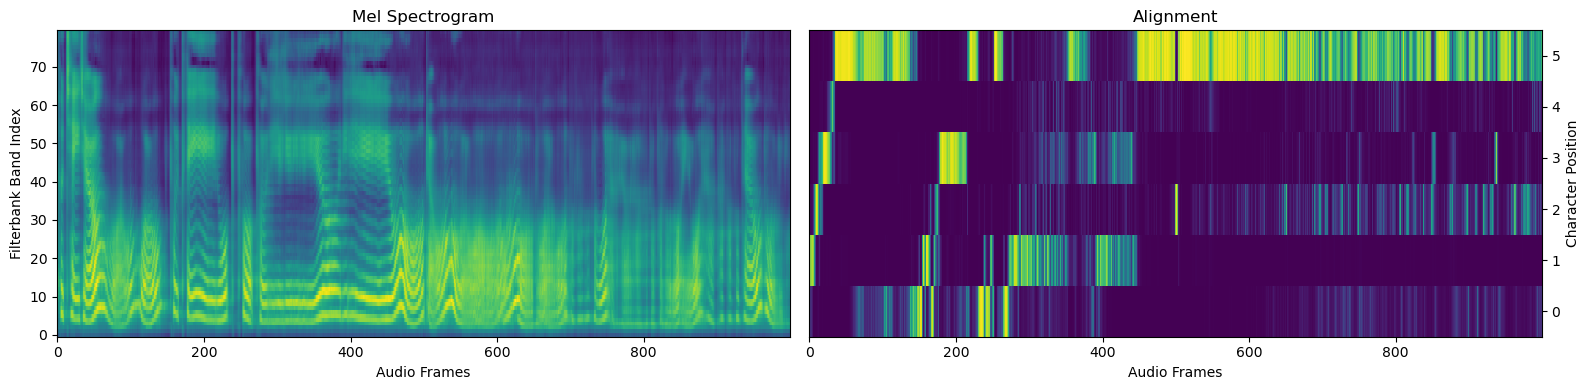

In [46]:
# Plot generated mel-spectrogram and attention alignment
fig = plot_data((mel_outputs.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))